In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

In [3]:
#load data/Load_MIDC_10yrs.csv as a dataframe
dfX = pd.read_csv("data/Temp_NWPP_10yrs.csv")
dfY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv")
#subtract 7 hours from datetime to convert from UTC to PST
dfY['datetime'] = pd.to_datetime(dfY['datetime'])
dfY['datetime'] = dfY['datetime'] - pd.Timedelta(hours=7)
dfX['datetime'] = pd.to_datetime(dfX['datetime'])
dfX['datetime'] = (dfX['datetime'] - pd.Timedelta(hours=7))

In [4]:
#groupby name and date, then find sum and max of load
selected_names = {
    'PGE': 'Portland General Electric Company',
    'AVA': 'Avista Corporation',
    'GCPD': 'PUD No. 2 of Grant County, Washington',
    'PSEI': 'Puget Sound Energy, Inc.',
    'TPWR': 'City of Tacoma, Department of Public Utilities',
    'BPA': 'BPA',
    'DOPD': 'PUD No. 1 of Douglas County',
    'SCL': 'Seattle City Light',
    'CHPD': 'Public Utility District No. 1 of Chelan County',
    'PACW': 'PACW-TAC',   # this line is different from EICLoadanalysis.ipynb
    'Total': 'Total'
}

In [5]:
Load=dfY[(dfY['name'].isin(list(selected_names.values())[:-1]))&(dfY['datetime'].dt.date > pd.to_datetime('2022-03-01').date())&(dfY['datetime'].dt.date < pd.to_datetime('2025-06-01').date())].groupby('datetime').agg({'avgvalue': 'sum'}).rename(columns={'avgvalue': 'Total Load'})
Temp=dfX[(dfX['station_name']=='NWPP')&(dfX['datetime'].dt.date > pd.to_datetime('2022-03-01').date())&(dfX['datetime'].dt.date < pd.to_datetime('2025-06-01').date())][['datetime','temperature']].set_index('datetime')

In [6]:

from pandas.tseries.holiday import USFederalHolidayCalendar
# Join the Load and Temp dataframes
Tload = Load.join(Temp)

# Remove outliers before fitting the model
Tload = Tload[(Tload['temperature'] >= 0) & (Tload['temperature'] <= 120)]
Tload = Tload.dropna()

# Prepare data for polynomial regression
Tload['date'] = Tload.index.dayofyear
Tload['month'] = Tload.index.month
Tload['year'] = Tload.index.year
Tload['time'] = Tload.index.hour

is_weekend = Tload.index.dayofweek.isin([5, 6])
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=Tload.index.min(), end=Tload.index.max()).to_pydatetime()
is_holiday = Tload.index.normalize().isin(holidays)

# 'On-Peak' is 1 for weekdays that are not holidays, and 0 otherwise
Tload['On-Peak'] = 1 - (is_weekend | is_holiday).astype(int)



In [15]:
# check if aveage load on off peak days is lower than on peak days
print("Average Load on On-Peak days:", Tload[Tload['On-Peak'] == 1]['Total Load'].mean())
print("Average Load on Off-Peak days:", Tload[Tload['On-Peak'] == 0]['Total Load'].mean())
#check the average load on weekends
print("Average Load on Weekends:", Tload[is_weekend]['Total Load'].mean())
#check the average load on holidays
print("Average Load on Holidays:", Tload[is_holiday]['Total Load'].mean())

Average Load on On-Peak days: 17567.74483140497
Average Load on Off-Peak days: 16558.502634157616
Average Load on Weekends: 16489.153932103247
Average Load on Holidays: 17249.949986993874


In [17]:
Tload.loc['2025-01-25']

,Total Load,temperature,date,month,year,time,On-Peak
datetime,,,,,,,
2025-01-25 00:00:00,20822.250000,31.0,25,1,2025,0,0
2025-01-25 01:00:00,20076.000000,32.0,25,1,2025,1,0
2025-01-25 02:00:00,19645.416667,31.0,25,1,2025,2,0
2025-01-25 03:00:00,19487.666667,30.0,25,1,2025,3,0
2025-01-25 04:00:00,19486.500000,29.0,25,1,2025,4,0
2025-01-25 05:00:00,19750.000000,28.0,25,1,2025,5,0
2025-01-25 06:00:00,20246.833333,28.0,25,1,2025,6,0
2025-01-25 07:00:00,21160.166667,27.0,25,1,2025,7,0
2025-01-25 08:00:00,22422.083333,26.0,25,1,2025,8,0


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Define features for the model
X = Tload[['temperature', 'date', 'month', 'year', 'time', 'On-Peak']]
y = Tload['Total Load']
# Create and fit the polynomial regression model (degree=3)
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Add the regression predictions to the Tload dataframe
Tload['Predicted Load'] = model.predict(X)

# Reset index to make 'datetime' a column for plotting
Tload = Tload.reset_index()

print(f"Polynomial Regression Model (degree={degree}) fitted.")
# Note: Coefficients for polynomial regression are more complex.
# You can inspect them via model.named_steps['linearregression'].coef_


Polynomial Regression Model (degree=2) fitted.


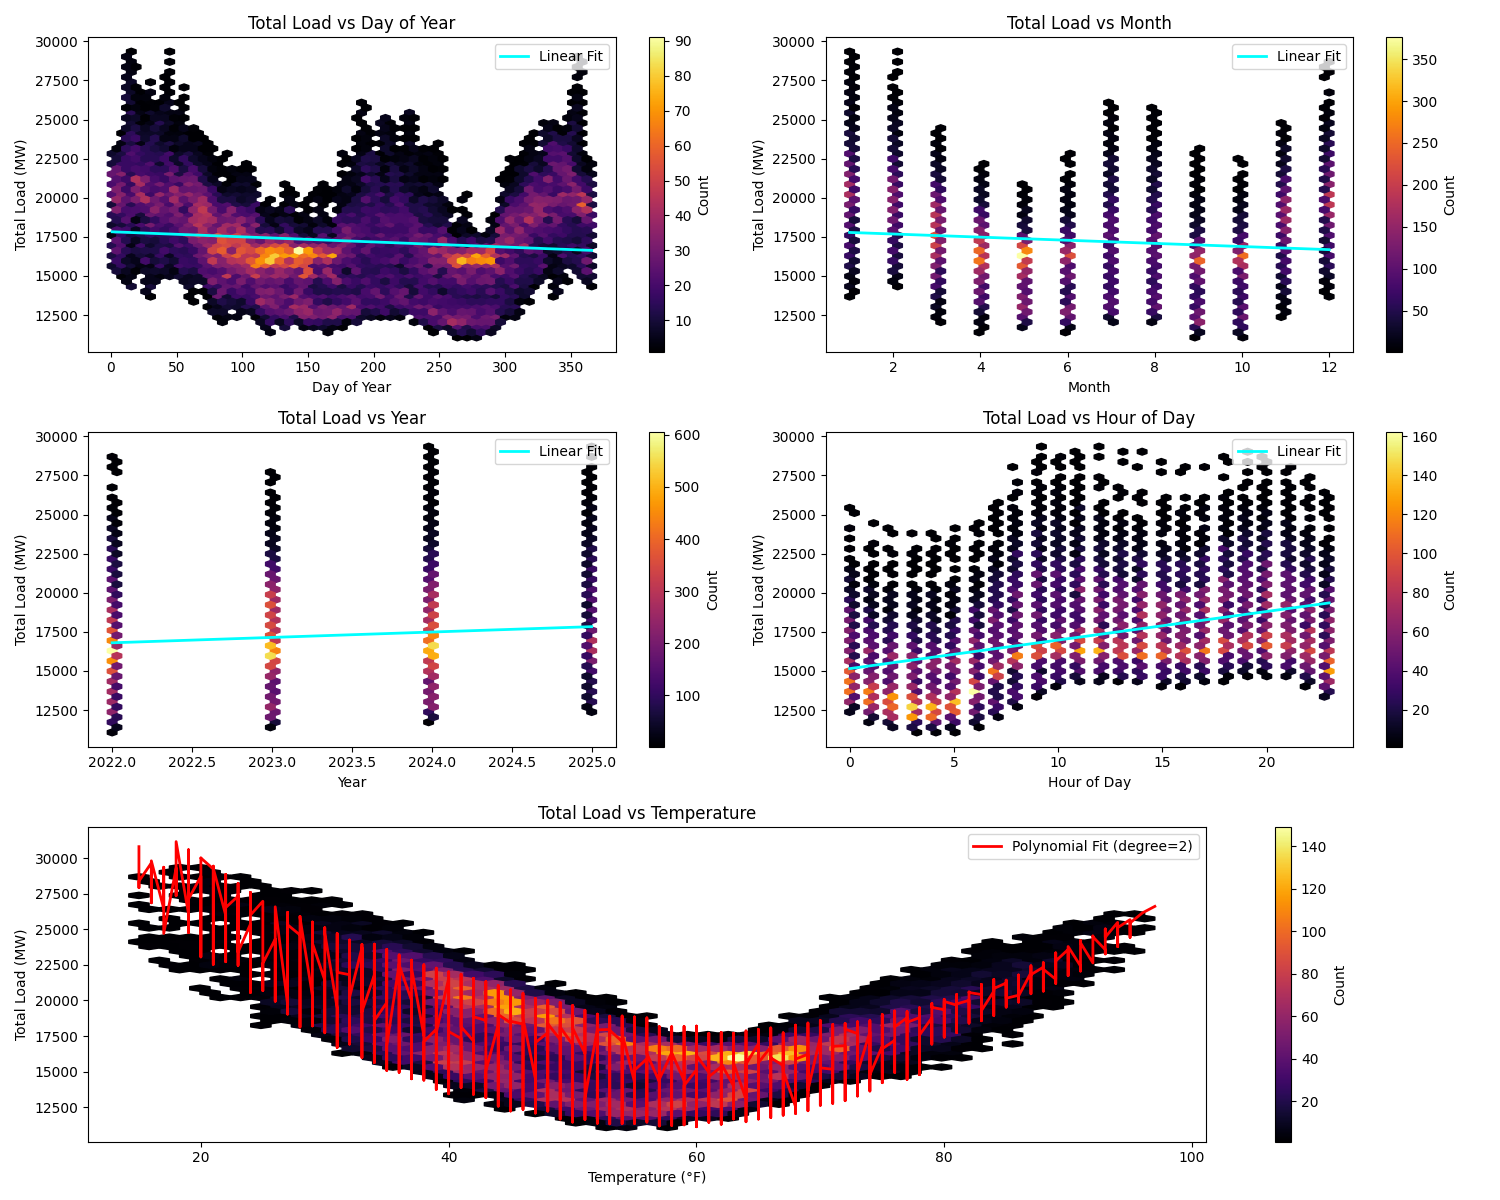

In [8]:
import numpy as np

import matplotlib.gridspec as gridspec

# Create a figure with a complex grid layout
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Create the 2x2 grid of subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Create the 1x2 subplot at the bottom
ax5 = fig.add_subplot(gs[2, :])

# List of axes and corresponding feature names for the top 4 plots
axes = [ax1, ax2, ax3, ax4]
features = ['date', 'month', 'year', 'time']
feature_names = ['Day of Year', 'Month', 'Year', 'Hour of Day']

# Plot scatter and regression for the 2x2 grid
for ax, feature, name in zip(axes, features, feature_names):
    # Use hexbin for density visualization
    hb = ax.hexbin(Tload[feature], Tload['Total Load'], gridsize=50, cmap='inferno', mincnt=1)
    
    # Fit a simple linear regression for visualization purposes
    p = np.polyfit(Tload[feature], Tload['Total Load'], 1)
    x_fit = np.linspace(Tload[feature].min(), Tload[feature].max(), 100)
    y_fit = np.polyval(p, x_fit)
    
    ax.plot(x_fit, y_fit, color='cyan', linewidth=2, label='Linear Fit')
    ax.set_xlabel(name)
    ax.set_ylabel('Total Load (MW)')
    ax.set_title(f'Total Load vs {name}')
    ax.legend()
    fig.colorbar(hb, ax=ax, label='Count')

# Plot for Total Load vs Temperature (bottom plot)
# Use hexbin for density visualization
hb5 = ax5.hexbin(Tload['temperature'], Tload['Total Load'], gridsize=50, cmap='inferno', mincnt=1)

# To plot the fitted line, we sort the values by temperature to get a smooth curve
sorted_Tload = Tload.sort_values('temperature')
ax5.plot(sorted_Tload['temperature'], sorted_Tload['Predicted Load'], color='red', linewidth=2, label=f'Polynomial Fit (degree={degree})')

ax5.set_xlabel('Temperature (°F)')
ax5.set_ylabel('Total Load (MW)')
ax5.set_title('Total Load vs Temperature')
ax5.legend()
fig.colorbar(hb5, ax=ax5, label='Count')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [8]:
plt.figure(figsize=(12, 6))
plt.hexbin(Tload['temperature'], Tload['Total Load'], gridsize=50, cmap='inferno', mincnt=1)
plt.colorbar(label='Count in Bin')
plt.plot(Tload['temperature'], Tload['Predicted Load'], color='red', label='Predicted Load', linewidth=2)
plt.title('Total Load vs Temperature with Quadratic Regression Line')
plt.xlabel('Temperature (°F)')
plt.ylabel('Total Load (MW)')
plt.legend()
#print R2 score
from sklearn.metrics import r2_score
r2 = r2_score(Tload['Total Load'], Tload['Predicted Load'])
print(f"R2 Score: {r2}")
plt.show()

<IPython.core.display.Javascript object>

R2 Score: 0.7823932041531412


<Axes: title={'center': 'Total Load from 2022-03-01 to 2025-06-01'}, xlabel='datetime'>

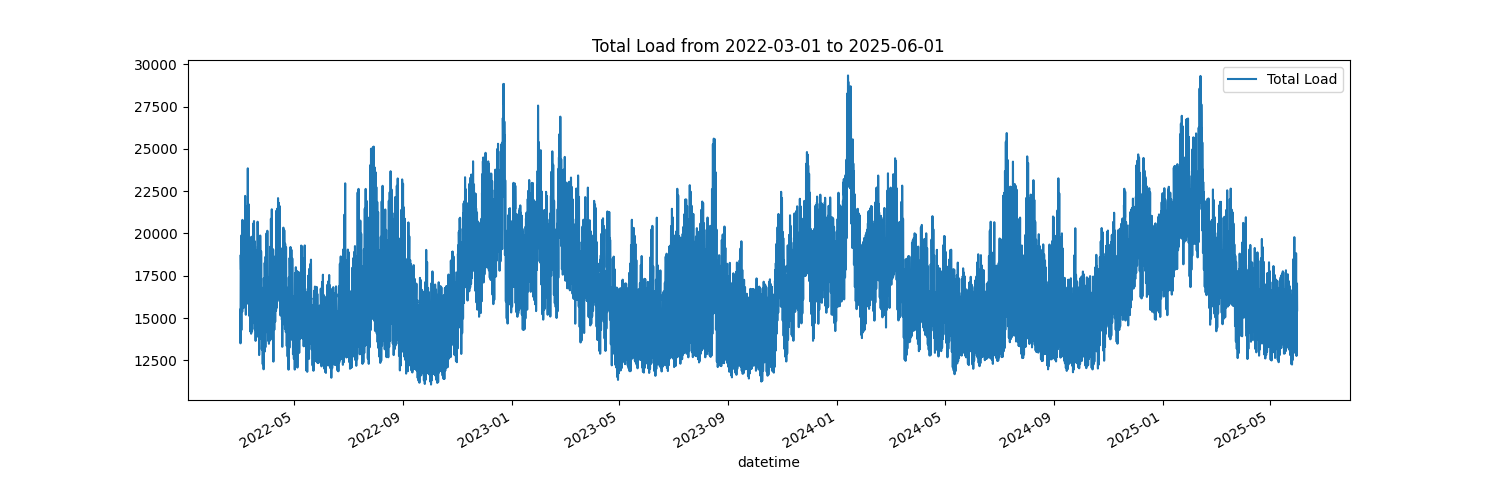

In [19]:
#plot Tload
Tload.plot(x='datetime', y='Total Load', figsize=(15, 5), title='Total Load from 2022-03-01 to 2025-06-01')

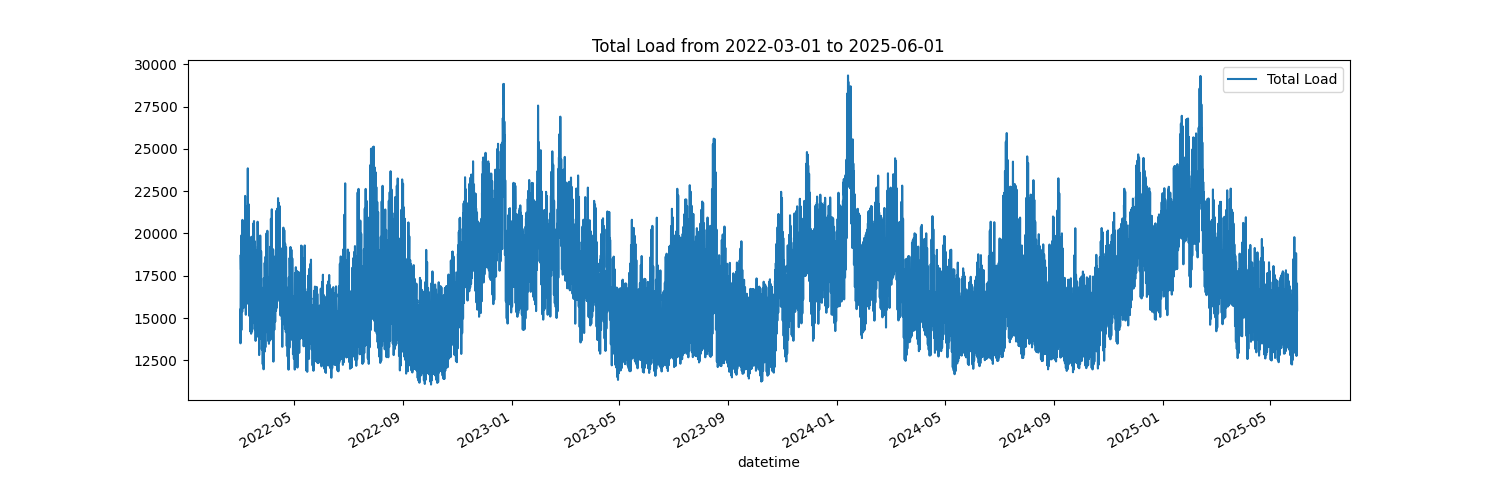

In [11]:
plt.show()

In [ ]:

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-01-01', end='2014-12-31').to_pydatetime()

In [9]:
holidays

array([datetime.datetime(2014, 1, 1, 0, 0),
       datetime.datetime(2014, 1, 20, 0, 0),
       datetime.datetime(2014, 2, 17, 0, 0),
       datetime.datetime(2014, 5, 26, 0, 0),
       datetime.datetime(2014, 7, 4, 0, 0),
       datetime.datetime(2014, 9, 1, 0, 0),
       datetime.datetime(2014, 10, 13, 0, 0),
       datetime.datetime(2014, 11, 11, 0, 0),
       datetime.datetime(2014, 11, 27, 0, 0),
       datetime.datetime(2014, 12, 25, 0, 0)], dtype=object)

In [10]:
# Define custom holidays based on the user's rules
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, MO
from pandas.tseries.offsets import DateOffset
class CustomHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=lambda d: d if d.weekday() != 6 else d + DateOffset(days=1)),
        Holiday('Memorial Day', month=5, day=31, offset=pd.DateOffset(weekday=MO(-1))),
        Holiday('Independence Day', month=7, day=4, observance=lambda d: d if d.weekday() != 6 else d + DateOffset(days=1)),
        Holiday('Labor Day', month=9, day=1, offset=pd.DateOffset(weekday=MO(1))),
        Holiday('Thanksgiving Day', month=11, day=1, offset=pd.DateOffset(weekday=MO(4))),
        Holiday('Christmas Day', month=12, day=25, observance=lambda d: d if d.weekday() != 6 else d + DateOffset(days=1))
    ]

# Get the holidays for the date range in the data
cal = CustomHolidayCalendar()
start_date = Tload.index.min()
end_date = Tload.index.max()
holidays = cal.holidays(start='2014-01-01', end='2014-12-31')

In [11]:
holidays

DatetimeIndex(['2014-01-01', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-11-24', '2014-12-25'],
              dtype='datetime64[ns]', freq=None)